In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import linalg as LA
from mpl_toolkits import mplot3d
import math
%matplotlib inline

In [70]:
def Aerodynamic_model_ODE_solver(V, t, params):
        #**Parameters**#
        #V: Initial position and velocity
        #t: time (s)
        #CD: Drag Coefficient
        #CL: lift Coefficient
        #M: Mass (Kg)
        #omega: Angular Velocity (rad/s)
        
        x0,y0,z0,vx,vy,vz = V     
        V=np.array([vx,vy,vz])
        CD, CL, Rho,M,d,W,omega = params   
        g=9.8            
        A=np.pi*d*d/4
        Vabs=V-W
        g=9.8
        eps=np.array([0.0001,0,0])
        omega=np.add(omega,eps)
        derivs = [vx,vy,vz,-0.5*Rho*A*LA.norm(Vabs)*(CD*(vx-W[0])- CL*((omega[1]*(vz-W[2]) - omega[2]*(vy-W[1]))/LA.norm(omega)))/M,      # list of dy/dt=f functions
             -0.5*rho*A*LA.norm(Vabs)*(CD*(vy-W[1])- CL*((omega[2]*(vx-W[0]) - omega[0]*(vz-W[2]))/LA.norm(omega)))/M,-0.5*rho*A*LA.norm(Vabs)*((CD*(vz-W[2]))- CL*((omega[0]*(vy-W[1]) - omega[1]*(vx-W[0]))/LA.norm(omega)))/M - g]
        return derivs

In [91]:
def spring_damper_impact_ODE_Solver(V, t, params):
        ###Parameters###
        #V: Initial conditions ODE
        #t: time (s)
        #a, c : Model coefficients
        #k: Spring constant
        
        z_c,v_c_z = V     
        a,d,m,V_c_z_0 = params  # unpack params           
        k=2.58*(10**11)*(np.e**(-0.319*abs(V_c_z_0)))
        q=5.35*(10**6)*np.e**(-0.157*abs(V_c_z_0))
        c=q*(z_c + d/2)*(d/2 - z_c)
        derivs = [v_c_z,float((k*(d/2 - z_c)**a)- c*v_c_z)]
        return derivs

In [109]:
def Spin_change_on_Impact(params,mu,r_gyration=0.00239):
    Omega_0,m,Z_c,V_z_c,V,delta_t,a,d,t,F_z_Avg= params
    k=2.58*(10**11)*(np.e**(-0.319*abs(V_z_c[0][0])))
    q=5.35*(10**6)*(np.e**(-0.157*abs(V_z_c[0][0])))
    c=q*(Z_c + d/2)*(d/2 - Z_c)
    
    if (LA.norm(Omega_0,ord=np.inf) < 10 ):
        mu=0 
        F_z_Avg=0
    
    eps=np.array([0.0000001,0,0])
    Omega_0=np.add(Omega_0,eps)
    
    #Normal Reaction force for at all the times
    F_z=np.array([[0]])
    F_z_1= (k*(d/2 - Z_c)**a)- c*V_z_c
    F_z=np.append(F_z,F_z_1)
    
    # Consider only positive values of normal reaction force
    F_z=F_z[F_z>=0]
    
    #F_z=np.ones((F_z.shape))*F_z_Avg
    F_z=np.reshape(F_z,(F_z.shape[0],1))
    
    #Calculate frictional force vector for all times
    F_friction=mu* F_z
    
    omega_net=np.array([-Omega_0[0][1]*d/2 ,Omega_0[0][0]*d/2,0])
    omega_net=np.reshape(omega_net,(1,3))
    Friction_dir=-np.reshape((omega_net/LA.norm(omega_net)),(1,3))
    
    Omega=Omega_0 
    Z_c=Z_c.T
    
    omega_t=Omega_0
    #We get direction of frictional force by rotating the omega vector by 90 deg CCW and taking the negative of it

    V_net= np.array([V[0][0],V[0][1],0])+np.array([-omega_t[0][1],omega_t[0][0],0])*d/2
    V_net=V_net.reshape((1,3))

    F_friction_vector= (F_friction).dot(Friction_dir)
    friction=np.array([F_friction_vector[0]])
    
    Friction_avg_vector=mu*np.array([F_z_Avg]).dot(Friction_dir)

    #V=((Friction_avg_vector*t[-1])/m)+V
    
    for i in range(1,F_friction.shape[0]):

        Omega_0=np.array([Omega[i-1]])
        Omega_0_dir=Omega_0/LA.norm(Omega_0)
        friction=np.append(friction,[F_friction_vector[i-1]],axis=0)
               
        #Update velocity vector using impulse-momentum equation
        V=((Friction_avg_vector*delta_t)/m)+V
        V[0][2]=V_z_c[0][i-1]
        
        #Update omega using Angular impulse -Angular momentum equation
        omega_t=Omega[i-1] + (np.cross(F_friction_vector[i-1],np.array([0,0,Z_c[i-1][0]])) * delta_t)/(m * (r_gyration**2))
        omega_net=np.array([-omega_t[1]*d/2 ,omega_t[0]*d/2,0])
        Friction_dir=-np.reshape((omega_net/LA.norm(omega_net)),(1,3))
        F_friction_vector= (F_friction).dot(Friction_dir)
        Omega=np.append(Omega,[omega_t],axis=0)
    

    return Omega,friction,V,F_z 



In [142]:
def Ball_Bounce_Model(M,D,W,Cd,Cl,Omega_0,rho,R_0,V_0,phi,mu):
    
    #Parameters
    #M: Mass of the ball (kg)
    #D: Diameter of the ball (m)
    #W : Wind Speed (m/s)
    #Cd : Drag Coefficient (Dimensionless)
    #Cl : Lift Coefficient (Dimensionless)
    #Omega_0 : Intial Angular velocity vector (rad/s): Numpy array of Dimension: 1*3 
    #rho: Air Density (kg/m^3)
    #R_0: Intial position vector of ball (m): List
    #V_0: Intitial speed (m/s):
    #phi: Angle of elevation or flight of the ball (degrees)
    #mu: Friction Coefficient
        
    #Initial velocity vector
    V_0_vector=[V_0*np.cos(np.deg2rad(phi)),0,V_0*np.sin(np.deg2rad(phi))]
    Ode_Input= R_0 + V_0_vector
    t_1 = np.arange(0, 1.65, 0.001)
    
    # Bundle parameters for AeroAerodynamic_model_ODE_solver
    params = [Cd, Cl, rho,m,D,W,Omega_0]
    
    #Aerodynamic modeling before impact with ground
    part_1 = odeint(Aerodynamic_model_ODE_solver, Ode_Input, t_1, args=(params,))
    part_1= part_1[part_1[:,2] >= float(D/2)]
    part_1= part_1[part_1[:,0] < 20]
    t_1=t_1[:part_1.shape[0]]
    
    #Spring-Damper model during impact with ground
    V_z=part_1[-1,5]
    Ode_2_Input=[float(D/2),V_z]
    t_2 = np.arange(0, 0.1, 0.0001)
    a=3.09
    V_z_c_0=V_z
    params=[a,D,M,V_z_c_0]
    part_2=odeint(spring_damper_impact_ODE_Solver, Ode_2_Input, t_2, args=(params,))
    part_2=part_2[part_2[:,0] < float(D/2)]
    t_2=t_2[:part_2.shape[0]]
    
    Z_c=part_2[:,0]
    Z_c=np.reshape(Z_c,(1,Z_c.shape[0]))

    V_z_c=part_2[:,1]
    V_z_c=np.reshape(V_z_c,(1,V_z_c.shape[0]))

    #Impulse-Momentum equation to find average normal force during impact
    Omega_0=np.array([Omega_0])
    F_z_Avg=(M/t_2[-1])*(part_2[-1,1]-part_2[0,1])
    
    #Spin and horizontal velocity changes on impact due to friction
    V_x, V_y,= part_1[-1,3],part_1[-1,4]
    V_=np.array([[V_x,V_y,V_z_c[0][0]]])
    
    delta_t=0.0001
    param=(Omega_0,M,Z_c,V_z_c,V_,delta_t,a,D,t_2,F_z_Avg)
    Omega_,Friction_force,V,F_z=Spin_change_on_Impact(param,mu=mu)
    
    Z_c=Z_c[:,:F_z.shape[0]]
    
    pts=F_z.shape[0]
    
    #Aerodynamic modeling after bouncing
    t_3 = np.arange(t_1[-1]+t_2[-1], 2.5, 0.001)
    Omega_0=[Omega_[-1,0],Omega_[-1,1],Omega_[-1,2]]
    params = [Cd, Cl, rho,m,D,W,Omega_0]
    Ode_3_Input=[part_1[-1,0],part_1[-1,1],part_1[-1,2],V[-1,0],V[-1,1],V[-1,2]]
    part_3 = odeint(Aerodynamic_model_ODE_solver, Ode_3_Input, t_3, args=(params,))
    part_3= part_3[part_3[:,0] <= 20.12]
    t_3=t_3[:part_3.shape[0]]
    Amount_of_spin=abs(part_1[-1,1]-part_3[-1,1])
    return part_1,part_2,part_3,t_2,Omega_,pts,Friction_force,F_z,Z_c

**Analysis to be done**
1)Force Deflection curves during impact with ground

2)Spring Damper bounce model profile

3)Bounce points for 5 deg,22m/s with and without wind

4)Sideways drift due to magnus or lift force and compare drifts in different spins, reproduce figure 17 from Robenson paper

5)The effect of the drag force and the presence of a wind on the trajectory and range of a cricket ball thrown from the boundary with an initial speed of 30 m s−1 (108 km h−1) and at an elevation angle of 25◦. Fig 15

6)Amount of spin in different frictional surfaces

0.11439221335071204


C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


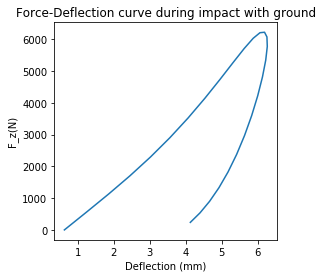

In [126]:
#1) Force Deflection curves during impact 
W=np.array([0,0,0])
#Initial position
r_0=[0,1.22,2]
#Initial speed
v_0=22

#flight given (elevation)
Phi=5
Cd=0.45
Mu=0.2
omega=np.array([-200,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
rho=1.22
m=1.59*0.1
D=7.2*0.01
A=np.pi*D*D/4

part_1_,part_2_,part_3_,t_2,Omega_,pts,Friction_force,F_z,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)
fig = plt.figure(3, figsize=(4,4))
ax2 = fig.add_subplot(111,title="Force-Deflection curve during impact with ground")
ax2.set_ylabel('F_z(N)') 
ax2.set_xlabel('Deflection (mm)') 
Z_c=np.absolute(Z_c-D/2)
ax2.plot(Z_c[0,:]*1000,F_z)

(1, 1.4)

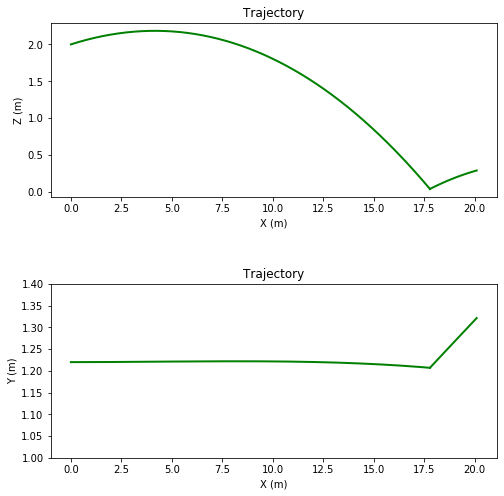

In [127]:
#plot x vs z
fig = plt.figure(3, figsize=(8,8))
fig.subplots_adjust(hspace=0.5)
ax3 = fig.add_subplot(211,title="Trajectory")
ax3.plot(part_1_[:,0], part_1_[:,2],'g',linewidth=2)
ax3.plot(part_3_[:,0], part_3_[:,2],'g',linewidth=2)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Z (m)' )

ax3 = fig.add_subplot(212,title="Trajectory")
ax3.plot(part_1_[:,0], part_1_[:,1],'g',linewidth=2)
ax3.plot(part_3_[:,0], part_3_[:,1],'g',linewidth=2)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_ylim([1,1.4])

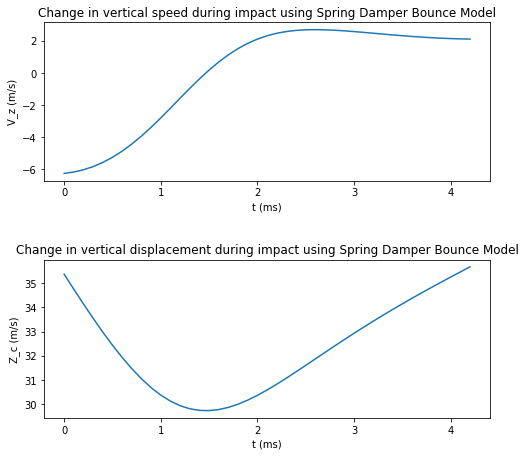

In [123]:
# 2) Plot spring damper bounce profiles
fig = plt.figure(3, figsize=(8,16))
fig.subplots_adjust(hspace=0.5)
ax2 = fig.add_subplot(411,title="Change in vertical speed during impact using Spring Damper Bounce Model")
ax2.set_xlabel('t (ms)')
ax2.set_ylabel('V_z (m/s)') 
ax2.plot(t_2*1000,part_2_[:,1])
ax3 = fig.add_subplot(412,title="Change in vertical displacement during impact using Spring Damper Bounce Model")
ax3.set_xlabel('t (ms)')
ax3.set_ylabel('Z_c (m/s)')
ax3.plot(t_2*1000,part_2_[:,0]*1000)

0.11639394245514234
0.17204548627629057


C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


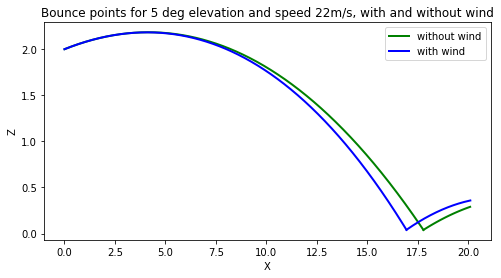

In [118]:
#3)Bounce points for 5 deg elevation and speed 22m/s, with and without wind
Phi=5
v_0=22
omega=np.array([150,0,0])
V_z_c_0=5
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))

#Without wind
W=np.array([0,0,0])
part_1,part_2,part_3,t_2,Omega_,pts,Friction_force,F_c,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

#With wind
W=np.array([-7.5,0,0])
part_12,part_22,part_32,t_22,Omega_1,pts_1,Friction_force_1,F_c,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

fig = plt.figure(3, figsize=(8,4))
fig.subplots_adjust(hspace=0.5)
    
#plot x vs z
ax3 = fig.add_subplot(111,title="Bounce points for 5 deg elevation and speed 22m/s, with and without wind")
ax3.plot(part_1[:,0], part_1[:,2],'g',label="without wind",linewidth=2)
ax3.plot(part_3[:,0], part_3[:,2],'g',linewidth=2)
ax3.plot(part_12[:,0], part_12[:,2],'b',label="with wind",linewidth=2)
ax3.plot(part_32[:,0], part_32[:,2],'b',linewidth=2)
ax3.set_xlabel('X')
ax3.set_ylabel('Z')
ax3.legend()

0.0
0.11639394245514234
0.056856243640036164
0.17204548627629057
0.022948382849112603


C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


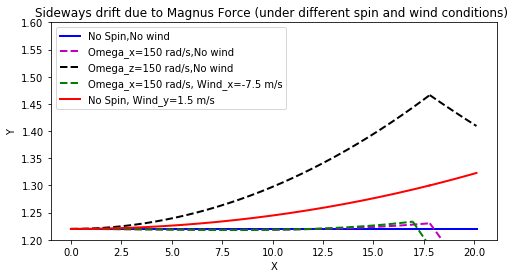

In [115]:
#4)Sideways drift due to magnus or lift force & compare drifts in different spins

Phi=5
v_0=22

#No Spin,No wind
omega=np.array([0,0,0])
W=np.array([0,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
part_1a,part_2a,part_3a,t_2a,Omega_,pts,Friction_force,F_z,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

#Omega_x=150 rad/s,No wind
omega=np.array([150,0,0])
W=np.array([0,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
part_12,part_22,part_32,t_22,Omega_2,pts_2,Friction_force_2,F_z_2,Z_c_2=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

#Omega_z=150 rad/s, No wind
omega=np.array([0,0,150])
W=np.array([0,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
part_13,part_23,part_33,t_23,Omega_3,pts_3,Friction_force_3,F_z,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

#Omega_x=150 rad/s, Wind_x=-7.5 m/s
omega=np.array([150,0,0])
W=np.array([-7.5,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
part_14,part_24,part_34,t_24,Omega_4,pts_4,Friction_force_4,F_z,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

#No Spin, Wind_y=1.5 m/s
omega=np.array([0,0,0])
W=np.array([0,1.5,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
part_15,part_25,part_35,t_25,Omega_5,pts_5,Friction_force_5,F_c,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)

fig = plt.figure(3, figsize=(8,4))
fig.subplots_adjust(hspace=0.5)

# Plot x vs y
ax2 = fig.add_subplot(111,title="Sideways drift due to Magnus Force (under different spin and wind conditions) ")
ax2.plot(part_1a[:,0], part_1a[:,1],'b',label="No Spin,No wind",linewidth=2)
ax2.plot(part_3a[:,0], part_3a[:,1],'b',linewidth=2)

ax2.plot(part_12[:,0], part_12[:,1],'m',linestyle='dashed',label="Omega_x=150 rad/s,No wind",linewidth=2)
ax2.plot(part_32[:,0], part_32[:,1],'m',linestyle='dashed',linewidth=2)

ax2.plot(part_13[:,0], part_13[:,1],'k',linestyle='dashed',label="Omega_z=150 rad/s,No wind",linewidth=2)
ax2.plot(part_33[:,0], part_33[:,1],'k',linestyle='dashed',linewidth=2)

ax2.plot(part_14[:,0], part_14[:,1],'g',linestyle='dashed',label="Omega_x=150 rad/s, Wind_x=-7.5 m/s",linewidth=2)
ax2.plot(part_34[:,0], part_34[:,1],'g',linestyle='dashed',linewidth=2)

ax2.plot(part_15[:,0], part_15[:,1],'r',label="No Spin, Wind_y=1.5 m/s",linewidth=2)
ax2.plot(part_35[:,0], part_35[:,1],'r',linewidth=2)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim([1.2,1.6])
ax2.legend()

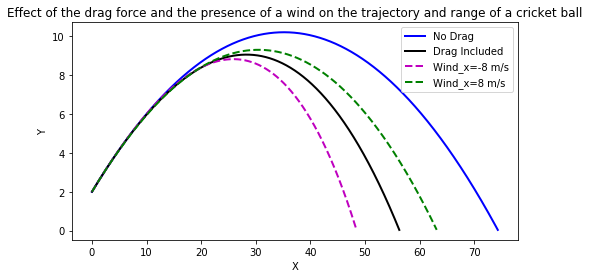

In [116]:
# 5)The effect of the drag force and the presence of a wind on the trajectory and range of a cricket ball thrown from the boundary with an initial speed of 30 m s−1 (108 km h−1) and at an elevation angle of 25◦. Fig 15
Phi=25
v_0=30
omega=np.array([0,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))

#Initial velocity vector
V_0_vector=[v_0*np.cos(np.deg2rad(Phi)),0,v_0*np.sin(np.deg2rad(Phi))]
Ode_Input= r_0 + V_0_vector
t_1 = np.arange(0, 5, 0.001)
 
#No drag
Cd=0
W=np.array([0,0,0])
params = [Cd, Cl, rho,m,D,W,omega]
part_11 = odeint(Aerodynamic_model_ODE_solver, Ode_Input, t_1, args=(params,))
part_11= part_11[part_11[:,2] >= float(D/2)]

#Drag Included
Cd=0.45
W=np.array([0,0,0])
params = [Cd, Cl, rho,m,D,W,omega]
part_12 = odeint(Aerodynamic_model_ODE_solver, Ode_Input, t_1, args=(params,))
part_12= part_12[part_12[:,2] >= float(D/2)]

#Wind_x=-8 m/s
W=np.array([-8,0,0])
params = [Cd, Cl, rho,m,D,W,omega]
part_13 = odeint(Aerodynamic_model_ODE_solver, Ode_Input, t_1, args=(params,))
part_13= part_13[part_13[:,2] >= float(D/2)]

#Wind_x=8 m/s
W=np.array([8,0,0])
params = [Cd, Cl, rho,m,D,W,omega]
part_14 = odeint(Aerodynamic_model_ODE_solver, Ode_Input, t_1, args=(params,))
part_14= part_14[part_14[:,2] >= float(D/2)]

fig = plt.figure(3, figsize=(8,4))
fig.subplots_adjust(hspace=0.5)

# Plot x vs y
ax2 = fig.add_subplot(111,title="Effect of the drag force and the presence of a wind on the trajectory and range of a cricket ball")
ax2.plot(part_11[:,0], part_11[:,2],'b',label="No Drag",linewidth=2)

ax2.plot(part_12[:,0], part_12[:,2],'k',label="Drag Included",linewidth=2)

ax2.plot(part_13[:,0], part_13[:,2],'m',linestyle='dashed',label="Wind_x=-8 m/s",linewidth=2)

ax2.plot(part_14[:,0], part_14[:,2],'g',linestyle='dashed',label="Wind_x=8 m/s",linewidth=2)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

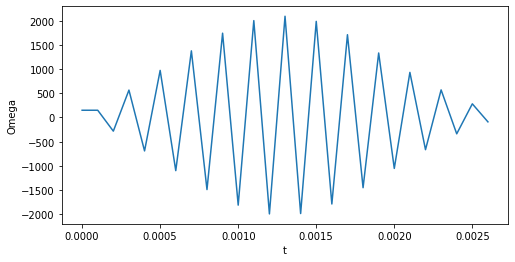

In [117]:
#Spin change during bounce
fig_1 = plt.figure(3, figsize=(8,4))
fig_1.subplots_adjust(hspace=.5)
ax4 = fig_1.add_subplot(111)
ax4.set_xlabel('t')
ax4.set_ylabel('Omega')
ax4.plot(t_22[:pts],Omega_2[:,0])

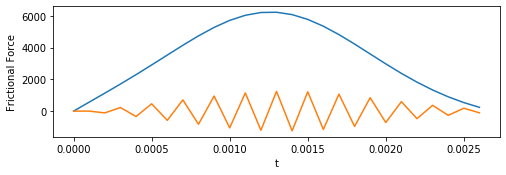

In [101]:
#Frictional force during bounce
fig_2 = plt.figure(3, figsize=(8,24))
fig_2.subplots_adjust(hspace=.5)
ax5 = fig_2.add_subplot(714)
ax5.set_xlabel('t')
ax5.set_ylabel('Frictional Force')
ax5.plot(t_22[:pts],F_z_2)
ax5.plot(t_22[:pts],Friction_force_2[:,1])

(1, 1.5)

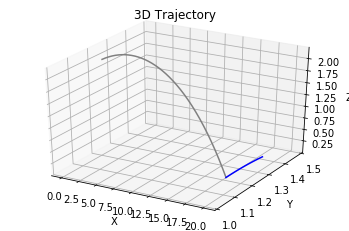

In [137]:
ax1= plt.axes(projection='3d',title="3D Trajectory")
ax1.plot3D(part_1_[:,0], part_1_[:,1],part_1_[:,2], 'gray')
ax1.plot3D(part_3_[:,0], part_3_[:,1],part_3_[:,2], 'blue')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_ylim(1,1.5)

C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\sachj\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


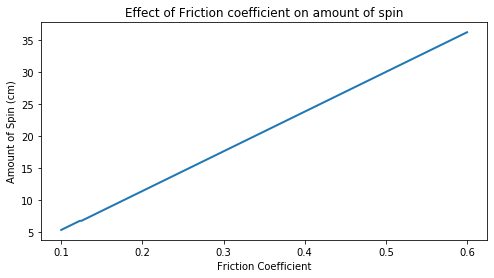

In [151]:
Mu_=np.linspace(0.1,0.6,200)
W=np.array([0,0,0])
spin_=[]
omega=np.array([-150,0,0])
for Mu in Mu_:
    part_15,part_25,part_35,t_25,Omega_5,pts_5,Friction_force_5,F_c,Z_c=Ball_Bounce_Model(m,D,W,Cd,Cl,omega,rho,r_0,v_0,Phi,Mu)
    spin=abs(part_15[-1,1]-part_35[-1,1])*100
    spin_.append(spin)
    
fig=plt.figure(3, figsize=(8,4))
ax2 = fig.add_subplot(111,title="Effect of Friction coefficient on amount of spin")
ax2.set_xlabel('Friction Coefficient')
ax2.set_ylabel('Amount of Spin (cm)')
ax2.plot(Mu_,spin_,linewidth=2)